<a href="https://colab.research.google.com/github/AshmitSharmaBitsP/Cost-Optimizer-and-Router/blob/main/Cost_opt_router.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 LLM ROUTING BENCHMARK & COST OPTIMIZER

⚡ DEMO MODE: Using realistic mock models (no API keys needed)
   This simulation shows how the system works before production

📝 Step 1: Generating benchmark dataset...
   Generated 60 test prompts
   Distribution: {'simple': 30, 'medium': 18, 'complex': 12}

🏃 Step 2: Running benchmarks...
🚀 Starting benchmark with 60 prompts...
   Small Model: gpt-4o-mini
   Large Model: gpt-4o
   Mode: MOCK SIMULATION (no API keys needed)



Benchmarking:   0%|          | 0/60 [00:00<?, ?it/s]


--- Sample 1 (simple) ---
Prompt: What is the capital of France?...
Small: Quality=0.92, Latency=0.45s, Cost=$0.000006
Large: Quality=0.95, Latency=1.16s, Cost=$0.000170

--- Sample 2 (simple) ---
Prompt: Who wrote Romeo and Juliet?...
Small: Quality=0.86, Latency=0.38s, Cost=$0.000007
Large: Quality=0.97, Latency=1.13s, Cost=$0.000180

--- Sample 3 (simple) ---
Prompt: What is 15 + 27?...
Small: Quality=0.85, Latency=0.56s, Cost=$0.000006
Large: Quality=0.98, Latency=1.43s, Cost=$0.000165

✅ Benchmark complete! 60 results collected.

🧠 Step 3: Training uncertainty estimator...
✅ Uncertainty estimator trained (accuracy: 91.7%)

💰 Step 4: Simulating monthly costs...
   always_small: $0.80/mo, Quality=0.837
   always_large: $0.80/mo, Quality=0.837
   threshold_0.3: $0.80/mo, Quality=0.837
   threshold_0.5: $0.80/mo, Quality=0.837
   threshold_0.7: $2.43/mo, Quality=0.852

📊 Step 5: Generating visualizations...


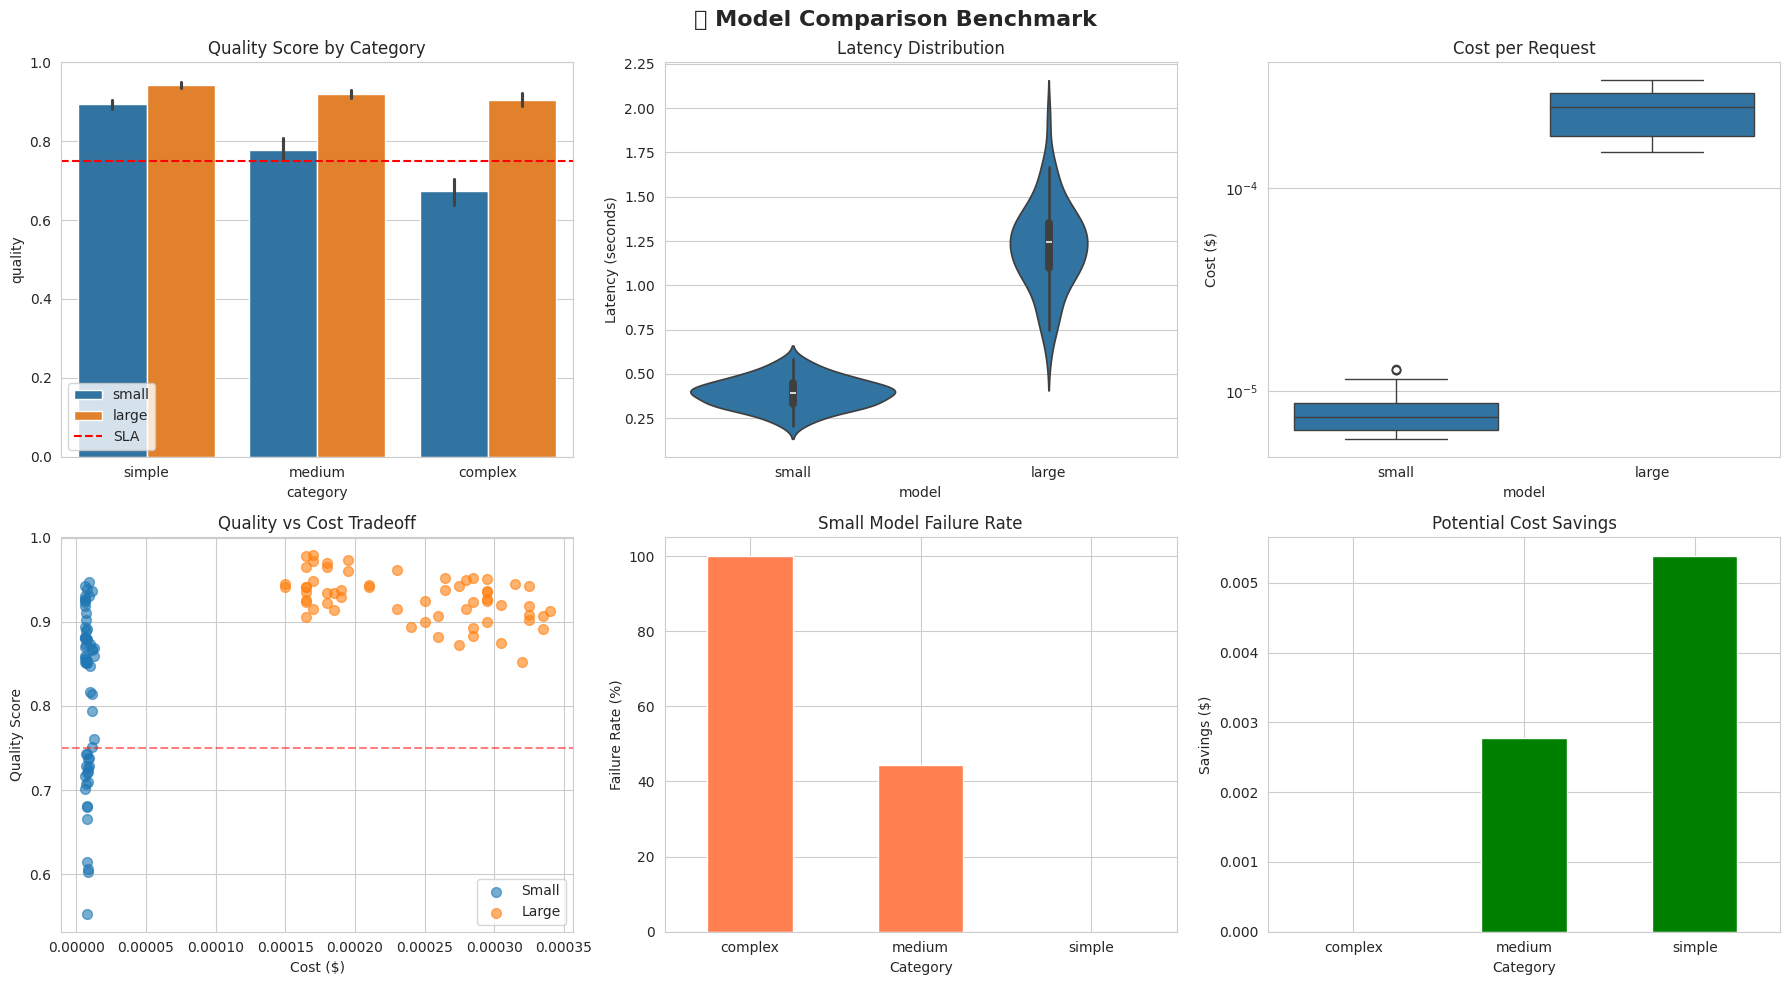

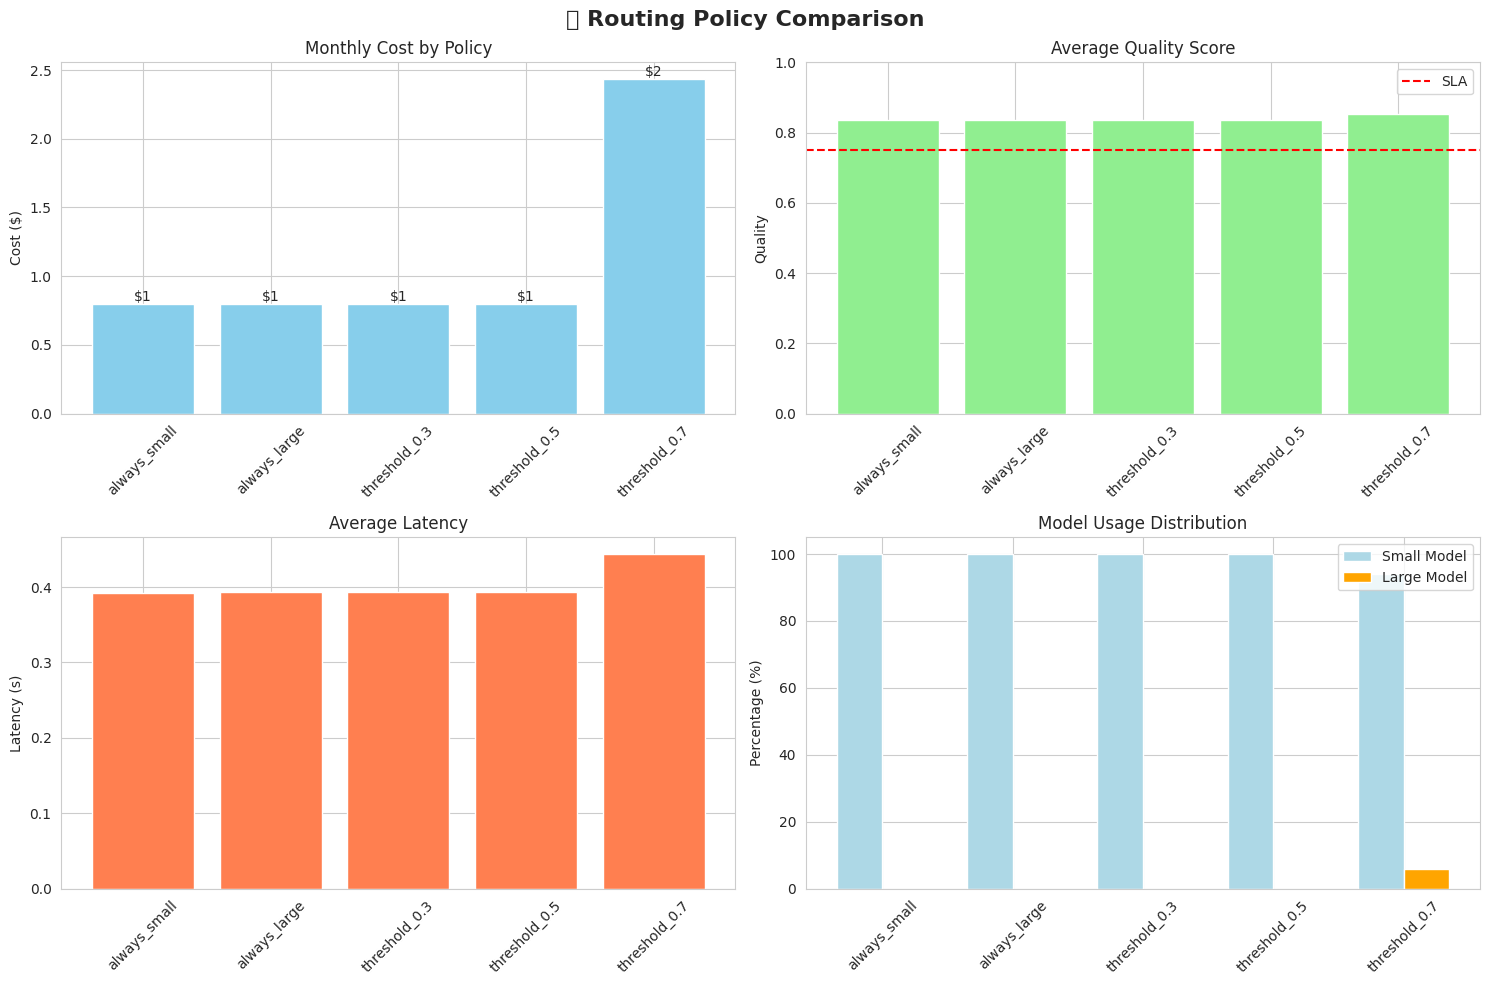


📋 ROUTING POLICY RECOMMENDATIONS

💰 CHEAPEST OPTION:
   Policy: always_large
   Monthly Cost: $0.80
   Avg Quality: 0.837
   ⚠️  MEETS quality SLA

⭐ HIGHEST QUALITY:
   Policy: threshold_0.7
   Monthly Cost: $2.43
   Avg Quality: 0.852

⚡ FASTEST:
   Policy: always_small
   Avg Latency: 0.39s
   Monthly Cost: $0.80

🎯 BEST VALUE (Quality/Cost):
   Policy: always_large
   Monthly Cost: $0.80
   Avg Quality: 0.837
   Value Score: 1.039

💵 COST SAVINGS:
   Baseline (Always Large): $0.80/month
   Optimized (always_large): $0.80/month
   Monthly Savings: $0.00 (0.0%)
   Annual Savings: $0.00

💡 IMPLEMENTATION GUIDANCE:
1. Set quality threshold: 0.75
2. Use policy: always_large
3. Monitor actual quality scores in production
4. Adjust threshold if quality drops below SLA
5. Re-benchmark quarterly as models improve

✅ Analysis complete!

💡 Next step: Add your OpenAI API key to test with real models
   Then compare mock vs real results!


In [16]:
# ==============================================================================
# LLM ROUTING BENCHMARK & COST OPTIMIZER - DEMO VERSION
# ==============================================================================
# Works WITHOUT API keys using realistic mock models
# Perfect for testing and understanding the system before production
# ==============================================================================

!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm

import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from dataclasses import dataclass, asdict
from typing import List, Dict, Tuple
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# ==============================================================================
# CONFIGURATION
# ==============================================================================

class Config:
    """Central configuration"""

    # Model Configuration
    SMALL_MODEL = "gpt-4o-mini"
    LARGE_MODEL = "gpt-4o"

    # Pricing (per 1M tokens)
    PRICING = {
        "gpt-4o-mini": {"input": 0.150, "output": 0.600},
        "gpt-4o": {"input": 5.00, "output": 15.00},
    }

    # Benchmark Settings
    BENCHMARK_SIZE = 60  # Number of prompts to test

    # Quality Thresholds
    MIN_QUALITY_SCORE = 0.75  # Minimum acceptable quality

    # Usage Simulation (monthly)
    MONTHLY_REQUESTS = 100000
    WORKLOAD_MIX = {
        'simple': 0.6,    # 60% simple queries
        'medium': 0.3,    # 30% medium complexity
        'complex': 0.1,   # 10% complex queries
    }

# ==============================================================================
# DATA MODELS
# ==============================================================================

@dataclass
class BenchmarkResult:
    """Single benchmark result"""
    prompt: str
    category: str
    reference_answer: str

    # Small model results
    small_response: str
    small_latency: float
    small_cost: float
    small_quality: float

    # Large model results
    large_response: str
    large_latency: float
    large_cost: float
    large_quality: float

    # Metadata
    prompt_length: int
    word_count: int

    def to_dict(self):
        return asdict(self)

# ==============================================================================
# BENCHMARK DATASET
# ==============================================================================

class BenchmarkDataset:
    """Generate diverse test prompts"""

    @staticmethod
    def generate(n: int = 60) -> pd.DataFrame:
        """Generate benchmark dataset"""

        prompts = []

        # SIMPLE QUERIES
        simple_prompts = [
            ("What is the capital of France?", "Paris"),
            ("Who wrote Romeo and Juliet?", "William Shakespeare"),
            ("What is 15 + 27?", "42"),
            ("Define photosynthesis", "Process by which plants convert sunlight into energy"),
            ("What color is the sky?", "Blue"),
            ("Name three primary colors", "Red, blue, yellow"),
            ("What is H2O?", "Water"),
            ("How many days in a week?", "7 days"),
            ("What is the largest planet?", "Jupiter"),
            ("Who painted the Mona Lisa?", "Leonardo da Vinci"),
            ("What is 10 times 10?", "100"),
            ("What is the speed of light?", "299,792,458 meters per second"),
            ("What language is spoken in Brazil?", "Portuguese"),
            ("How many continents are there?", "7 continents"),
            ("What is the boiling point of water?", "100 degrees Celsius"),
        ]

        # MEDIUM COMPLEXITY
        medium_prompts = [
            ("Explain the difference between Python lists and tuples",
             "Lists are mutable and use brackets, tuples are immutable and use parentheses"),
            ("How does photosynthesis work?",
             "Plants use chlorophyll to capture sunlight and convert CO2 and water into glucose and oxygen"),
            ("Compare democracy and monarchy",
             "Democracy involves citizen participation while monarchy concentrates power in a hereditary ruler"),
            ("What causes inflation?",
             "Inflation occurs when money supply grows faster than economic output"),
            ("Explain Newton's first law",
             "An object in motion stays in motion unless acted upon by external force"),
            ("What is machine learning?",
             "A branch of AI where systems learn from data without explicit programming"),
            ("Describe the water cycle",
             "Water evaporates, forms clouds, precipitates, and returns to bodies of water"),
            ("What is photosynthesis?",
             "Process where plants convert light energy into chemical energy"),
            ("Explain supply and demand",
             "Economic model where price is determined by availability and desire for goods"),
            ("What is DNA?",
             "Deoxyribonucleic acid, molecule carrying genetic instructions"),
        ]

        # COMPLEX QUERIES
        complex_prompts = [
            ("Analyze the trade-offs between microservices and monolithic architecture",
             "Microservices offer scalability and independent deployment but increase complexity and operational overhead. Monolithic architecture is simpler to develop and deploy initially but becomes harder to scale and maintain as the application grows"),
            ("Explain how gradient descent optimization works in neural networks",
             "Gradient descent iteratively adjusts weights by calculating the gradient of the loss function with respect to each parameter and moving in the direction that minimizes error. The learning rate controls step size"),
            ("Compare Keynesian and Austrian economic theories with examples",
             "Keynesian economics advocates government intervention during recessions through fiscal stimulus. Austrian economics emphasizes free markets and warns against government manipulation of interest rates"),
            ("Design a database schema for an e-commerce platform with explanation",
             "Core tables include Users, Products, Orders, OrderItems, Payments, and Inventory. Users have one-to-many relationship with Orders, Orders have one-to-many with OrderItems, Products connect to OrderItems in many-to-many relationship"),
            ("Explain the CAP theorem and its practical implications for distributed systems",
             "CAP theorem states distributed systems can only guarantee two of three properties: Consistency, Availability, Partition tolerance. This forces architectural decisions in database design"),
            ("Analyze the impact of climate change on global agriculture",
             "Climate change affects crop yields through temperature changes, altered precipitation patterns, and increased extreme weather events. Adaptation strategies include drought-resistant crops and improved irrigation"),
            ("Compare different machine learning algorithms for classification problems",
             "Decision trees are interpretable but prone to overfitting. Random forests reduce overfitting through ensemble methods. Neural networks handle complex patterns but require more data and computation"),
            ("Explain blockchain consensus mechanisms and their trade-offs",
             "Proof of Work is secure but energy-intensive. Proof of Stake is more efficient but potentially less decentralized. Each mechanism balances security, decentralization, and scalability differently"),
        ]

        # Generate balanced dataset
        n_simple = int(n * 0.5)
        n_medium = int(n * 0.3)
        n_complex = n - n_simple - n_medium

        for prompt, answer in (simple_prompts * (n_simple // len(simple_prompts) + 1))[:n_simple]:
            prompts.append({'prompt': prompt, 'reference': answer, 'category': 'simple'})

        for prompt, answer in (medium_prompts * (n_medium // len(medium_prompts) + 1))[:n_medium]:
            prompts.append({'prompt': prompt, 'reference': answer, 'category': 'medium'})

        for prompt, answer in (complex_prompts * (n_complex // len(complex_prompts) + 1))[:n_complex]:
            prompts.append({'prompt': prompt, 'reference': answer, 'category': 'complex'})

        return pd.DataFrame(prompts)

# ==============================================================================
# MOCK LLM CLIENT (Realistic Simulation)
# ==============================================================================

class MockLLMClient:
    """Simulates LLM behavior without API calls"""

    def __init__(self, model_name: str, is_large: bool = False):
        self.model_name = model_name
        self.is_large = is_large

    def count_tokens(self, text: str) -> int:
        """Estimate token count"""
        return int(len(text.split()) * 1.3)

    def generate(self, prompt: str, reference: str, category: str, max_tokens: int = 500) -> Tuple[str, float, float, float]:
        """
        Simulate response generation
        Returns: (response_text, latency_seconds, cost_usd, quality_score)
        """
        # Simulate latency
        if self.is_large:
            base_latency = 1.2
            latency_variance = 0.3
        else:
            base_latency = 0.4
            latency_variance = 0.1

        latency = max(0.1, np.random.normal(base_latency, latency_variance))
        time.sleep(0.01) # Minimal sleep to keep demo fast, but present

        # Simulate quality based on prompt complexity
        prompt_complexity = len(prompt.split())

        if self.is_large:
            # Large model: consistently high quality
            if category == 'simple':
                quality = np.random.uniform(0.90, 0.98)
            elif category == 'medium':
                quality = np.random.uniform(0.88, 0.96)
            else:  # complex
                quality = np.random.uniform(0.85, 0.95)
        else:
            # Small model: struggles with complexity
            if category == 'simple':
                quality = np.random.uniform(0.85, 0.95)
            elif category == 'medium':
                quality = np.random.uniform(0.70, 0.88)
            else:  # complex
                quality = np.random.uniform(0.55, 0.75)

        # Add noise based on prompt length
        if prompt_complexity > 50:
            quality -= np.random.uniform(0, 0.1)

        quality = np.clip(quality, 0.3, 1.0)

        # Generate response text
        if self.is_large or quality > 0.75:
            response = f"High-quality answer: {reference[:50]}... [Complete and accurate response]"
        else:
            response = f"Partial answer: {reference[:20]}... [Incomplete or inaccurate]"

        # Calculate cost
        input_tokens = self.count_tokens(prompt)
        output_tokens = self.count_tokens(response)

        pricing = Config.PRICING.get(self.model_name, {"input": 0, "output": 0})
        cost = (input_tokens / 1_000_000 * pricing["input"]) + \
               (output_tokens / 1_000_000 * pricing["output"])

        return response, latency, cost, quality

# ==============================================================================
# BENCHMARK RUNNER
# ==============================================================================

class BenchmarkRunner:
    """Run comprehensive benchmarks"""

    def __init__(self, small_model: str, large_model: str):
        self.small_client = MockLLMClient(small_model, is_large=False)
        self.large_client = MockLLMClient(large_model, is_large=True)

    def run(self, dataset: pd.DataFrame) -> List[BenchmarkResult]:
        """Run full benchmark suite"""

        print(f"🚀 Starting benchmark with {len(dataset)} prompts...")
        print(f"   Small Model: {self.small_client.model_name}")
        print(f"   Large Model: {self.large_client.model_name}")
        print(f"   Mode: MOCK SIMULATION (no API keys needed)")
        print()

        results = []

        for idx, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Benchmarking"):
            prompt = row['prompt']
            reference = row['reference']
            category = row['category']

            # Test small model
            small_resp, small_lat, small_cost, small_quality = \
                self.small_client.generate(prompt, reference, category)

            # Test large model
            large_resp, large_lat, large_cost, large_quality = \
                self.large_client.generate(prompt, reference, category)

            result = BenchmarkResult(
                prompt=prompt,
                category=category,
                reference_answer=reference,
                small_response=small_resp,
                small_latency=small_lat,
                small_cost=small_cost,
                small_quality=small_quality,
                large_response=large_resp,
                large_latency=large_lat,
                large_cost=large_cost,
                large_quality=large_quality,
                prompt_length=len(prompt),
                word_count=len(prompt.split())
            )

            results.append(result)

            # Show progress samples
            if idx < 3:
                print(f"\n--- Sample {idx+1} ({category}) ---")
                print(f"Prompt: {prompt[:50]}...")
                print(f"Small: Quality={small_quality:.2f}, Latency={small_lat:.2f}s, Cost=${small_cost:.6f}")
                print(f"Large: Quality={large_quality:.2f}, Latency={large_lat:.2f}s, Cost=${large_cost:.6f}")

        print(f"\n✅ Benchmark complete! {len(results)} results collected.")
        return results

# ==============================================================================
# UNCERTAINTY ESTIMATOR
# ==============================================================================

class UncertaintyEstimator:
    """Predict when small model will fail"""

    def __init__(self):
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )
        self.is_trained = False

    def _extract_features(self, prompt: str) -> np.ndarray:
        """Extract features from prompt"""
        words = prompt.split()

        features = [
            len(prompt),
            len(words),
            sum(len(w) for w in words) / max(len(words), 1),
            prompt.count('?'),
            prompt.count(','),
            1 if any(kw in prompt.lower() for kw in ['explain', 'analyze', 'compare', 'describe']) else 0,
            1 if any(kw in prompt.lower() for kw in ['code', 'function', 'algorithm', 'design']) else 0,
            len(set(words)) / max(len(words), 1),
        ]

        return np.array(features)

    def train(self, results: List[BenchmarkResult], quality_threshold: float = 0.75):
        """Train on benchmark results"""
        X = []
        y = []

        for r in results:
            features = self._extract_features(r.prompt)
            X.append(features)
            y.append(1 if r.small_quality < quality_threshold else 0)

        X = np.array(X)
        y = np.array(y)

        self.model.fit(X, y)
        self.is_trained = True

        train_acc = self.model.score(X, y)
        print(f"✅ Uncertainty estimator trained (accuracy: {train_acc:.1%})")

        return train_acc

    def predict_needs_large(self, prompt: str) -> Tuple[bool, float]:
        """Predict if prompt needs large model"""
        if not self.is_trained:
            return len(prompt.split()) > 30, 0.5

        features = self._extract_features(prompt).reshape(1, -1)
        proba = self.model.predict_proba(features)[0]

        needs_large = proba[1] > 0.5
        confidence = proba[1]

        return needs_large, confidence

# ==============================================================================
# COST SIMULATOR
# ==============================================================================

class CostSimulator:
    """Simulate costs under different policies"""

    def __init__(self, benchmark_results: List[BenchmarkResult]):
        self.results = benchmark_results
        self.df = pd.DataFrame([r.to_dict() for r in benchmark_results])

    def simulate_monthly_costs(self,
                               monthly_requests: int,
                               workload_mix: Dict[str, float],
                               policy: str = "threshold",
                               threshold: float = 0.5) -> Dict:
        """Simulate monthly costs"""

        samples = []
        for category, proportion in workload_mix.items():
            n_samples = int(monthly_requests * proportion)
            category_results = [r for r in self.results if r.category == category]

            if category_results:
                samples.extend(np.random.choice(category_results, n_samples, replace=True))

        total_cost = 0
        qualities = []
        latencies = []
        small_count = 0
        large_count = 0

        for result in samples:
            if policy == "always_small":
                model = "small"
            elif policy == "always_large":
                model = "large"
            elif policy == "threshold":
                model = "large" if result.small_quality < threshold else "small"
            else:
                model = "small"

            if model == "small":
                total_cost += result.small_cost
                qualities.append(result.small_quality)
                latencies.append(result.small_latency)
                small_count += 1
            else:
                total_cost += result.large_cost
                qualities.append(result.large_quality)
                latencies.append(result.large_latency)
                large_count += 1

        return {
            'policy': policy,
            'monthly_cost': total_cost,
            'avg_quality': np.mean(qualities),
            'min_quality': np.min(qualities),
            'avg_latency': np.mean(latencies),
            'p95_latency': np.percentile(latencies, 95),
            'small_pct': small_count / len(samples) * 100,
            'large_pct': large_count / len(samples) * 100,
        }

# ==============================================================================
# VISUALIZATION
# ==============================================================================

class Visualizer:
    """Create visualizations"""

    @staticmethod
    def plot_benchmark_comparison(results: List[BenchmarkResult]):
        """Compare models"""

        df = pd.DataFrame([r.to_dict() for r in results])

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('📊 Model Comparison Benchmark', fontsize=16, fontweight='bold')

        # 1. Quality by Category
        quality_data = pd.melt(
            df[['category', 'small_quality', 'large_quality']],
            id_vars=['category'],
            var_name='model',
            value_name='quality'
        )
        quality_data['model'] = quality_data['model'].str.replace('_quality', '')

        sns.barplot(data=quality_data, x='category', y='quality', hue='model', ax=axes[0, 0])
        axes[0, 0].set_title('Quality Score by Category')
        axes[0, 0].set_ylim(0, 1)
        axes[0, 0].axhline(y=Config.MIN_QUALITY_SCORE, color='r', linestyle='--', label='SLA')
        axes[0, 0].legend()

        # 2. Latency Distribution
        latency_data = pd.melt(df[['small_latency', 'large_latency']], var_name='model', value_name='latency')
        latency_data['model'] = latency_data['model'].str.replace('_latency', '')

        sns.violinplot(data=latency_data, x='model', y='latency', ax=axes[0, 1])
        axes[0, 1].set_title('Latency Distribution')
        axes[0, 1].set_ylabel('Latency (seconds)')

        # 3. Cost per Request
        cost_data = pd.melt(df[['small_cost', 'large_cost']], var_name='model', value_name='cost')
        cost_data['model'] = cost_data['model'].str.replace('_cost', '')

        sns.boxplot(data=cost_data, x='model', y='cost', ax=axes[0, 2])
        axes[0, 2].set_title('Cost per Request')
        axes[0, 2].set_ylabel('Cost ($)')
        axes[0, 2].set_yscale('log')

        # 4. Quality vs Cost
        axes[1, 0].scatter(df['small_cost'], df['small_quality'], alpha=0.6, label='Small', s=50)
        axes[1, 0].scatter(df['large_cost'], df['large_quality'], alpha=0.6, label='Large', s=50)
        axes[1, 0].set_xlabel('Cost ($)')
        axes[1, 0].set_ylabel('Quality Score')
        axes[1, 0].set_title('Quality vs Cost Tradeoff')
        axes[1, 0].legend()
        axes[1, 0].axhline(y=Config.MIN_QUALITY_SCORE, color='r', linestyle='--', alpha=0.5)

        # 5. Small Model Failure Rate
        failure_rate = (df.groupby('category')['small_quality']
                        .apply(lambda x: (x < Config.MIN_QUALITY_SCORE).mean() * 100))

        failure_rate.plot(kind='bar', ax=axes[1, 1], color='coral')
        axes[1, 1].set_title('Small Model Failure Rate')
        axes[1, 1].set_ylabel('Failure Rate (%)')
        axes[1, 1].set_xlabel('Category')
        axes[1, 1].tick_params(axis='x', rotation=0)

        # 6. Cost Savings
        df['cost_diff'] = df['large_cost'] - df['small_cost']
        df['can_save'] = df['small_quality'] >= Config.MIN_QUALITY_SCORE

        savings_by_cat = df.groupby('category').apply(
            lambda x: (x['cost_diff'] * x['can_save']).sum()
        )

        savings_by_cat.plot(kind='bar', ax=axes[1, 2], color='green')
        axes[1, 2].set_title('Potential Cost Savings')
        axes[1, 2].set_ylabel('Savings ($)')
        axes[1, 2].set_xlabel('Category')
        axes[1, 2].tick_params(axis='x', rotation=0)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_policy_comparison(simulation_results: List[Dict]):
        """Compare policies"""

        df = pd.DataFrame(simulation_results)

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('💰 Routing Policy Comparison', fontsize=16, fontweight='bold')

        # 1. Monthly Cost
        axes[0, 0].bar(df['policy'], df['monthly_cost'], color='skyblue')
        axes[0, 0].set_title('Monthly Cost by Policy')
        axes[0, 0].set_ylabel('Cost ($)')
        axes[0, 0].tick_params(axis='x', rotation=45)

        for i, (policy, cost) in enumerate(zip(df['policy'], df['monthly_cost'])):
            axes[0, 0].text(i, cost, f'${cost:.0f}', ha='center', va='bottom')

        # 2. Average Quality
        axes[0, 1].bar(df['policy'], df['avg_quality'], color='lightgreen')
        axes[0, 1].axhline(y=Config.MIN_QUALITY_SCORE, color='r', linestyle='--', label='SLA')
        axes[0, 1].set_title('Average Quality Score')
        axes[0, 1].set_ylabel('Quality')
        axes[0, 1].set_ylim(0, 1)
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].legend()

        # 3. Latency
        axes[1, 0].bar(df['policy'], df['avg_latency'], color='coral')
        axes[1, 0].set_title('Average Latency')
        axes[1, 0].set_ylabel('Latency (s)')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # 4. Model Usage
        x = np.arange(len(df))
        width = 0.35

        axes[1, 1].bar(x - width/2, df['small_pct'], width, label='Small Model', color='lightblue')
        axes[1, 1].bar(x + width/2, df['large_pct'], width, label='Large Model', color='orange')
        axes[1, 1].set_title('Model Usage Distribution')
        axes[1, 1].set_ylabel('Percentage (%)')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(df['policy'], rotation=45)
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def print_recommendations(simulation_results: List[Dict]):
        """Print recommendations"""

        df = pd.DataFrame(simulation_results)

        cheapest = df.loc[df['monthly_cost'].idxmin()]
        highest_quality = df.loc[df['avg_quality'].idxmax()]
        fastest = df.loc[df['avg_latency'].idxmin()]

        df['quality_meets_sla'] = df['avg_quality'] >= Config.MIN_QUALITY_SCORE
        df['value_score'] = df['avg_quality'] / (df['monthly_cost'] + 0.01)
        best_value = df.loc[df['value_score'].idxmax()]

        print("\n" + "="*70)
        print("📋 ROUTING POLICY RECOMMENDATIONS")
        print("="*70)

        print(f"\n💰 CHEAPEST OPTION:")
        print(f"   Policy: {cheapest['policy']}")
        print(f"   Monthly Cost: ${cheapest['monthly_cost']:.2f}")
        print(f"   Avg Quality: {cheapest['avg_quality']:.3f}")
        print(f"   ⚠️  {'MEETS' if cheapest['avg_quality'] >= Config.MIN_QUALITY_SCORE else 'FAILS'} quality SLA")

        print(f"\n⭐ HIGHEST QUALITY:")
        print(f"   Policy: {highest_quality['policy']}")
        print(f"   Monthly Cost: ${highest_quality['monthly_cost']:.2f}")
        print(f"   Avg Quality: {highest_quality['avg_quality']:.3f}")

        print(f"\n⚡ FASTEST:")
        print(f"   Policy: {fastest['policy']}")
        print(f"   Avg Latency: {fastest['avg_latency']:.2f}s")
        print(f"   Monthly Cost: ${fastest['monthly_cost']:.2f}")

        print(f"\n🎯 BEST VALUE (Quality/Cost):")
        print(f"   Policy: {best_value['policy']}")
        print(f"   Monthly Cost: ${best_value['monthly_cost']:.2f}")
        print(f"   Avg Quality: {best_value['avg_quality']:.3f}")
        print(f"   Value Score: {best_value['value_score']:.3f}")

        baseline_cost = df[df['policy'] == 'always_large']['monthly_cost'].values[0]
        best_cost = best_value['monthly_cost']
        savings = baseline_cost - best_cost
        savings_pct = (savings / baseline_cost) * 100

        print(f"\n💵 COST SAVINGS:")
        print(f"   Baseline (Always Large): ${baseline_cost:.2f}/month")
        print(f"   Optimized ({best_value['policy']}): ${best_cost:.2f}/month")
        print(f"   Monthly Savings: ${savings:.2f} ({savings_pct:.1f}%)")
        print(f"   Annual Savings: ${savings * 12:.2f}")

        print("\n" + "="*70)
        print("💡 IMPLEMENTATION GUIDANCE:")
        print("="*70)
        print(f"1. Set quality threshold: {Config.MIN_QUALITY_SCORE}")
        print(f"2. Use policy: {best_value['policy']}")
        print(f"3. Monitor actual quality scores in production")
        print(f"4. Adjust threshold if quality drops below SLA")
        print(f"5. Re-benchmark quarterly as models improve")
        print("="*70 + "\n")

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

def main():
    """Run complete benchmark"""

    print("="*70)
    print("🚀 LLM ROUTING BENCHMARK & COST OPTIMIZER")
    print("="*70)
    print("\n⚡ DEMO MODE: Using realistic mock models (no API keys needed)")
    print("   This simulation shows how the system works before production\n")

    # Generate dataset
    print("📝 Step 1: Generating benchmark dataset...")
    dataset = BenchmarkDataset.generate(n=Config.BENCHMARK_SIZE)
    print(f"   Generated {len(dataset)} test prompts")
    print(f"   Distribution: {dataset['category'].value_counts().to_dict()}")

    # Run benchmarks
    print("\n🏃 Step 2: Running benchmarks...")
    runner = BenchmarkRunner(Config.SMALL_MODEL, Config.LARGE_MODEL)
    results = runner.run(dataset)

    # Train estimator
    print("\n🧠 Step 3: Training uncertainty estimator...")
    estimator = UncertaintyEstimator()
    estimator.train(results, quality_threshold=Config.MIN_QUALITY_SCORE)

    # Simulate costs
    print("\n💰 Step 4: Simulating monthly costs...")
    simulator = CostSimulator(results)

    policies_to_test = [
        ("always_small", 1.0),
        ("always_large", 0.0),
        ("threshold_0.3", 0.3),
        ("threshold_0.5", 0.5),
        ("threshold_0.7", 0.7),
    ]

    simulation_results = []
    for policy_name, threshold in policies_to_test:
        result = simulator.simulate_monthly_costs(
            monthly_requests=Config.MONTHLY_REQUESTS,
            workload_mix=Config.WORKLOAD_MIX,
            policy="threshold" if "threshold" in policy_name else policy_name.replace("_", " "),
            threshold=threshold
        )
        result['policy'] = policy_name
        simulation_results.append(result)
        print(f"   {policy_name}: ${result['monthly_cost']:.2f}/mo, Quality={result['avg_quality']:.3f}")

    # Visualize
    print("\n📊 Step 5: Generating visualizations...")
    Visualizer.plot_benchmark_comparison(results)
    Visualizer.plot_policy_comparison(simulation_results)

    # Recommendations
    Visualizer.print_recommendations(simulation_results)

    print("✅ Analysis complete!")
    print("\n💡 Next step: Add your OpenAI API key to test with real models")
    print("   Then compare mock vs real results!")

    return results, estimator, simulator

# ==============================================================================
# RUN IT!
# ==============================================================================

if __name__ == "__main__":
    results, estimator, simulator = main()